In [13]:
import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from liquidity.response_functions import fit
from liquidity.response_functions.price_response_functions import compute_conditional_aggregate_impact
from liquidity.util.utils import bin_data_into_quantiles
from liquidity.util.goodness_of_fit import compute_rsquared
from liquidity.response_functions.features import compute_aggregate_features
from liquidity.response_functions.functional_form import scaling_form, rescaled_form

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Window/bin size
T = 1000

In [5]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## Finding scaling parameters

Scaling function – $\mathscr{F}(x) = \frac{x}{(1 + |x|^\alpha)^{\frac{\beta}{\alpha}}}$
Scaling form –  $R(ΔV,T) \approx R(1) \times T^{\chi} \times  \mathscr{F}\left(\frac{ΔV}{T^{\kappa}}\right)$
Rescaled form – $R(ΔV) \approx R_T \times  \mathscr{F}\left(\frac{ΔV}{\mathcal{E}_T}\right)$

In order to map out the scale factors  $R_T$ and $\mathcal{E}_T$ we use the following approach:

Part $I$:

   – Fit scaling form on all $T$ in the data to determine a heuristic guess of the scaling parameters $\alpha$, $\beta$,  $\chi$ and $\kappa$.

   – Use found shape parameters $\alpha$ and $\beta$ and scaling exponents $\chi$ and $\kappa$ to approximate an initial renormalization of data.

Part $II$:

   – Once the found parameters $\alpha$ and $\beta$ of $\mathscr{F}(x)$ are fixed, we use them to map out scale factors $R_T$ and $\mathcal{E}_T$ by
     fitting the rescaled form $R(ΔV)$  as a funtion of $T$, which are accurately described by a power law $R_T \sim T^\chi$, $\mathcal{E}_T \sim T^\kappa$.

   – Use the mapped out scale factors to extract the fitted scaling exponents and perform a renomalization of the data to obtain the final master curves.

## 1. Part $I$: Fit scaling form $R(ΔV,T)$ on normalised data

In [6]:
FITTING_LAGS = [10, 20, 50, 100, 150]

In [18]:
norm_agg_features_df = compute_aggregate_features(appl_raw_df, FITTING_LAGS)

In [19]:
norm_agg_features_df

,event_timestamp,midprice,sign,signed_volume,price_changing,vol_imbalance,sign_imbalance,price_changing_imbalance,daily_R1,daily_vol,daily_num,T
0,2016-01-04 10:30:00.447086945,103.285,-1,-0.057404,False,-0.596054,-2,4,0.005362,3559870,18358,10
1,2016-01-04 10:30:02.766885463,103.255,-1,-0.382692,False,0.967049,2,4,0.005362,3559870,18358,10
2,2016-01-04 10:30:03.786539659,103.220,1,0.448260,False,7.162071,6,6,0.005362,3559870,18358,10
3,2016-01-04 10:30:05.887745114,103.255,-1,-0.191346,False,0.881369,4,2,0.005362,3559870,18358,10
4,2016-01-04 10:30:14.823822084,103.275,1,0.343495,True,1.279668,2,6,0.005362,3559870,18358,10
...,...,...,...,...,...,...,...,...,...,...,...,...
16721,2016-12-30 14:23:48.176351503,115.685,-1,-1.108287,True,-9.674544,2,76,0.004487,1641959,6559,150
16722,2016-12-30 14:34:30.655715419,115.645,-1,-0.178573,False,0.350197,10,62,0.004487,1641959,6559,150
16723,2016-12-30 14:45:54.555871081,115.675,-1,-0.283449,True,-4.460561,-8,78,0.004487,1641959,6559,150
16724,2016-12-30 14:51:34.386489043,115.575,1,0.011873,True,-16.511156,-4,67,0.004487,1641959,6559,150


In [20]:
norm_agg_features_df = compute_conditional_aggregate_impact(norm_agg_features_df)

In [21]:
norm_agg_features_df

,event_timestamp,midprice,sign,signed_volume,price_changing,vol_imbalance,sign_imbalance,price_changing_imbalance,daily_R1,daily_vol,daily_num,T,R
0,2016-01-04 10:30:00.447086945,103.285,-1,-0.057404,False,-1.674370e-07,-0.000109,4,0.005362,3559870,18358,10,-5.594677
1,2016-01-04 10:30:02.766885463,103.255,-1,-0.382692,False,2.716530e-07,0.000109,4,0.005362,3559870,18358,10,-6.527123
2,2016-01-04 10:30:03.786539659,103.220,1,0.448260,False,2.011891e-06,0.000327,6,0.005362,3559870,18358,10,6.527123
3,2016-01-04 10:30:05.887745114,103.255,-1,-0.191346,False,2.475845e-07,0.000218,2,0.005362,3559870,18358,10,3.729785
4,2016-01-04 10:30:14.823822084,103.275,1,0.343495,True,3.594705e-07,0.000109,6,0.005362,3559870,18358,10,3.729785
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16721,2016-12-30 14:23:48.176351503,115.685,-1,-1.108287,True,-4.280233e-06,0.000305,76,0.004487,1641959,6559,150,-8.914713
16722,2016-12-30 14:34:30.655715419,115.645,-1,-0.178573,False,2.132801e-07,0.001525,62,0.004487,1641959,6559,150,6.686035
16723,2016-12-30 14:45:54.555871081,115.675,-1,-0.283449,True,-2.716610e-06,-0.001220,78,0.004487,1641959,6559,150,-22.286782
16724,2016-12-30 14:51:34.386489043,115.575,1,0.011873,True,-4.280233e-06,-0.000610,67,0.004487,1641959,6559,150,-17.829426


In [22]:
norm_fit_result_dict = {}
for lag in FITTING_LAGS:
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31, duplicates="drop")

    norm_fit_result_dict[lag] = fit.fit_scaling_form(data_binned)

Optimal parameters not found: The maximum number of function evaluations is exceeded
Optimal parameters not found: The maximum number of function evaluations is exceeded
Optimal parameters not found: The maximum number of function evaluations is exceeded


TypeError: Value after * must be an iterable, not NoneType

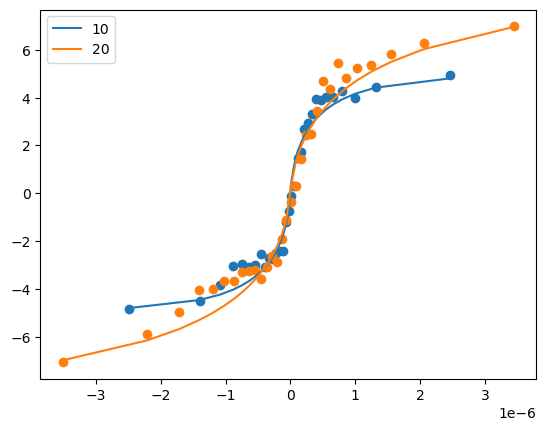

In [24]:
residual_dict = {}
for lag, fit_result in norm_fit_result_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result[0]
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31, duplicates="drop")
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    plt.plot(imbalance_T[0], y_hat, label=f"{lag}")
    plt.legend()

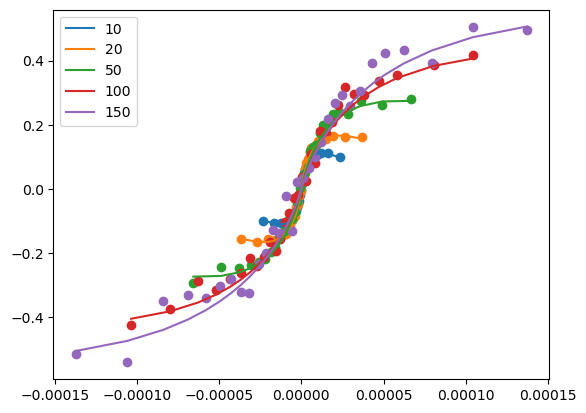

In [16]:
residual_dict = {}
for lag, fit_result in norm_fit_result_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result[0]
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    plt.plot(imbalance_T[0], y_hat, label=f"{lag}")
    plt.legend()

In [22]:
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp
for lag in residual_dict.keys():
    fit_result = norm_fit_result_dict[lag]
    param = fit_result[0]

    r2, ar2 = compute_rsquared(*residual_dict[lag], param)
    mse = mean_squared_error(ys, y_hat)
    ks_distance = ks_2samp(ys, y_hat, alternative="two-sided")
    print(f"For T={lag} \n R2 = {r2}, \n Adj R2 = {ar2}, \n ks_distance = {ks_distance} \n \n")

For T=10 
 R2 = 0.9977083386920073, 
 Adj R2 = 0.9972500064304087, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=20 
 R2 = 0.9963951457633112, 
 Adj R2 = 0.9956741749159734, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=50 
 R2 = 0.9929644274269085, 
 Adj R2 = 0.9915573129122902, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=100 
 R2 = 0.9857183691241517, 
 Adj R2 = 0.982862042948982, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pvalue=0.9634297148886908, statistic_location=-0.3519384530954189, statistic_sign=-1) 
 

For T=150 
 R2 = 0.9771940080671632, 
 Adj R2 = 0.9726328096805958, 
 ks_distance = KstestResult(statistic=0.12903225806451613, pval

# Fit scaling form on renormalised data

In [71]:
MO_LAG_INTERVALS = list(range(1, T))

In [72]:
# popt_ebay, pcov_ebay, fit_func_ebay, data_norm_ebay = compute_shape_parameters(ebay_raw_df, MO_LAG_INTERVALS)
# popt_msft, pcov_msft, fit_func_msft, data_norm_msft = compute_shape_parameters(msft_raw_df, MO_LAG_INTERVALS)
# popt_appl, pcov_appl, fit_func_appl, data_norm_appl = compute_shape_parameters(appl_raw_df, MO_LAG_INTERVALS)
# popt_nflx, pcov_nflx, fit_func_nflx, data_norm_nflx = compute_shape_parameters(nflx_raw_df, MO_LAG_INTERVALS)
# popt_amzn, pcov_amzn, fit_func_amzn, data_norm_amzn = compute_shape_parameters(amzn_raw_df, MO_LAG_INTERVALS)

In [73]:
result_all = {
#     'TSLA': (popt_tsla, pcov_tsla, fit_func, data_norm),
#     'EBAY': (popt_ebay, pcov_ebay, fit_func_ebay, data_norm_ebay),
#     'MSFT': (popt_msft, pcov_msft, fit_func_msft, data_norm_msft),
#     'APPL': (popt_appl, pcov_appl, fit_func_appl, data_norm_appl),
#     'NFLX': (popt_nflx, pcov_nflx, fit_func_nflx, data_norm_nflx),
#     'AMZN': (popt_amzn, pcov_amzn, fit_func_amzn, data_norm_amzn)
}

In [74]:
import pickle
# pickle.dump(result_all, open('../../data/generated/shape_parameters_mo.pkl', 'wb'))
shape_params_dict = pickle.load(open('../../data/generated/shape_parameters_mo.pkl', 'rb'))
shape_params_dict.keys()

dict_keys(['TSLA', 'EBAY', 'MSFT', 'APPL', 'NFLX', 'AMZN'])

In [75]:
# Parameters of master curve

In [76]:
appl_shape_params = shape_params_dict['APPL']

In [77]:
popt_appl, pcov_appl, fit_func_appl, data_norm_appl = appl_shape_params

In [78]:
chi, kappa, alpha, beta, gamma = popt_appl

In [79]:
chi

0.5277979122995787

In [80]:
kappa

0.8282064394561939

In [81]:
alpha

0.521073801226079

In [82]:
beta

868.318406822373

In [83]:
param = shape_params_dict['APPL']

In [84]:
COLLAPSE_LAGS = [10, 20, 50, 100, 150]

In [85]:
norm_agg_features_df_for_durations = norm_agg_features_df[norm_agg_features_df['T'].isin(COLLAPSE_LAGS)]

### Compare fits of individual curves to the renormalised data

In [86]:
"""
* fit scaling form on all renormalised data
"""

'\n* fit scaling form on all renormalised data\n'

In [87]:
renomalized_param_dict = renormalise(norm_agg_features_df_for_durations, popt_appl, durations=COLLAPSE_LAGS)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:31: RuntimeWarning: overflow encountered in power
  


In [88]:
for k,v in renomalized_param_dict.items():
    mape = v.params[1]
    print(f"for lag {k} mape is {mape}")

for lag 10 mape is [[ 1.31036271e+12  7.80207963e+07 -2.01714564e+04  1.47418541e+11
  -6.28539780e+12]
 [ 7.80207963e+07  3.59097339e+05 -1.31226716e+02  6.77730464e+08
  -3.72540624e+08]
 [-2.01714564e+04 -1.31226716e+02  4.99069415e-02 -2.47627104e+05
   9.61322820e+04]
 [ 1.47418541e+11  6.77730464e+08 -2.47627104e+05  1.27909292e+12
  -7.03910857e+11]
 [-6.28539780e+12 -3.72540624e+08  9.61322820e+04 -7.03910857e+11
   3.01490846e+13]]
for lag 20 mape is [[ 8.20317630e+11  7.07184187e+07 -3.18382078e+04  2.23120644e+11
  -4.74577500e+12]
 [ 7.07184187e+07  4.02935857e+05 -1.55236884e+02  1.27195463e+09
  -4.06830218e+08]
 [-3.18382078e+04 -1.55236884e+02  6.37348032e-02 -4.89940186e+05
   1.83310838e+05]
 [ 2.23120644e+11  1.27195463e+09 -4.89940186e+05  4.01520383e+12
  -1.28356867e+12]
 [-4.74577500e+12 -4.06830218e+08  1.83310838e+05 -1.28356867e+12
   2.74556958e+13]]
for lag 50 mape is [[ 1.01916780e+12 -1.19196413e+08  6.55867304e+04 -2.57854144e+11
  -6.47656103e+12]
 [-1.1

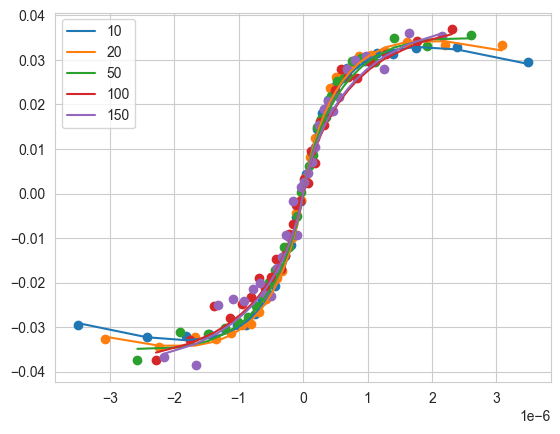

In [89]:
residual_dict = {}
for lag, fit_result in renomalized_param_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result.params[0]
    data = fit_result.data
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    plt.plot(imbalance_T[0], y_hat, label=f"{lag}")
    plt.legend()

In [90]:
for lag in renomalized_param_dict.keys():
    fit_result = renomalized_param_dict[lag]
    param = fit_result.params[0]

    r2, ar2 = compute_rsquared(*residual_dict[lag], param)
    print(f"For T={lag} \n R2 = {r2}, \n Adj R2 = {ar2} \n \n,")

For T=10 
 R2 = 0.9977076637487758, 
 Adj R2 = 0.997249196498531 
 
,
For T=20 
 R2 = 0.996393940090043, 
 Adj R2 = 0.9956727281080516 
 
,
For T=50 
 R2 = 0.9929622510022579, 
 Adj R2 = 0.9915547012027095 
 
,
For T=100 
 R2 = 0.9857136502549779, 
 Adj R2 = 0.9828563803059736 
 
,
For T=150 
 R2 = 0.97719016639156, 
 Adj R2 = 0.972628199669872 
 
,


### Compare master curve fit to the renormalised data

In [ ]:
"""
plot data points for larger lags
"""

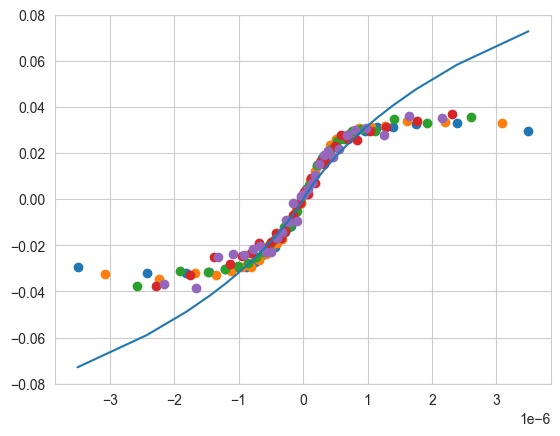

In [37]:
residual_dict = {}
for lag, fit_result in renomalized_param_dict.items():
    # plt.figure(figsize=(4, 4))
    param = shape_params_dict['APPL'][0]

    data = fit_result.data
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    imbalance_T = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(imbalance_T, *param)
    residuals = ys - y_hat
    residual_dict[lag] = residuals, ys

    plt.scatter(xs, ys)
    if lag == 10:
        plt.plot(imbalance_T[0], y_hat)

In [38]:
for lag in renomalized_param_dict.keys():
    fit_result = renomalized_param_dict[lag]
    param = fit_result.params[0]

    r2, ar2 = compute_rsquared(*residual_dict[lag], param)
    print(f"For T={lag} \n R2 = {r2}, \n Adj R2 = {ar2} \n \n,")

For T=10 
 R2 = 0.6786714226334276, 
 Adj R2 = 0.6144057071601132 
 
,
For T=20 
 R2 = 0.7817964636753583, 
 Adj R2 = 0.73815575641043 
 
,
For T=50 
 R2 = 0.8812604787417242, 
 Adj R2 = 0.857512574490069 
 
,
For T=100 
 R2 = 0.9043577201834311, 
 Adj R2 = 0.8852292642201173 
 
,
For T=150 
 R2 = 0.8686312138931592, 
 Adj R2 = 0.8423574566717911 
 
,


## 1.2. After Collapse

In [39]:
"""
Lage beta:

- fix 1: restraint volume imbalance scope when fitting (requires re-running fit of scaling form for each N each stock

- temp fix 2: remove outliers in the series of RN and QN

"""

'\nLage beta:\n\n- fix 1: restraint volume imbalance scope when fitting (requires re-running fit of scaling form for each N each stock\n\n- temp fix 2: remove outliers in the series of RN and QN\n\n'

## 2. Fitting Rescaled Form on normalised data

    - Find RN, QN, given Alpha, Beta

Approach II: produce series of RN and QN by fitting scaling funtion for different N, then use powerlaw library to fit power law and determine scale factors; finally, fit known scaling form to find exponents and then use them for renormalisation.

In [40]:
LAGS = list(range(1, 1001))

In [ ]:
# # Aggregate orderflow
# tsla_imbalance = get_agg_features(tsla_raw_df, LAGS, remove_outliers=False)
# pickle.dump(tsla_imbalance, open('../../data/generated/tsla_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# msft_imbalance = get_agg_features(msft_raw_df, LAGS, remove_outliers=False)
# pickle.dump(msft_imbalance, open('../../data/generated/msft_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# amzn_imbalance= get_agg_features(amzn_raw_df, LAGS, remove_outliers=False)
# pickle.dump(amzn_imbalance, open('../../data/generated/amzn_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# nflx_imbalance = get_agg_features(nflx_raw_df, LAGS,remove_outliers=False)
# pickle.dump(nflx_imbalance, open('../../data/generated/nflx_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# ebay_imbalance = get_agg_features(ebay_raw_df, LAGS, remove_outliers=False)
# pickle.dump(ebay_imbalance, open('../../data/generated/ebay_aggregate_features_mo_df.pkl', 'wb'))

In [ ]:
# appl_imbalance = get_agg_features(appl_raw_df, LAGS,remove_outliers=False)
# pickle.dump(appl_imbalance, open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'wb'))

### Load pre-computed data

In [41]:
appl_features_df = pickle.load(open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'rb'))

In [42]:
from IPython.display import display
display(appl_features_df.head())

,event_timestamp,midprice,vol_imbalance,sign_imbalance,sign,daily_R1,daily_vol,daily_num,R,T
0,2017-01-03 10:30:19.351489154,219.325,2.934072e-08,0.000305,1,0.021159,277786,3279,0.000,1
1,2017-01-03 10:30:19.351537884,219.325,4.401108e-07,0.000305,1,0.021159,277786,3279,0.005,1
2,2017-01-03 10:30:19.351549791,219.330,2.347257e-06,0.000305,1,0.021159,277786,3279,0.005,1
3,2017-01-03 10:30:19.351601187,219.335,2.347257e-06,0.000305,1,0.021159,277786,3279,0.000,1
4,2017-01-03 10:30:19.351702603,219.335,1.173629e-06,0.000305,1,0.021159,277786,3279,0.050,1


### Generate series of RN and QN by fitting scaling form with known parameters of alpha and beta

In [43]:
from liquidity.response_functions.fit import compute_RN_QN

In [44]:
# fit powerlaw on series of RN and QN ranges
RN_df, QN_df, RN_fit_object, QN_fit_object = compute_RN_QN(appl_features_df, alpha, beta)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:42: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/functional_form.py:42: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(abs(x), alpha), beta / alpha)


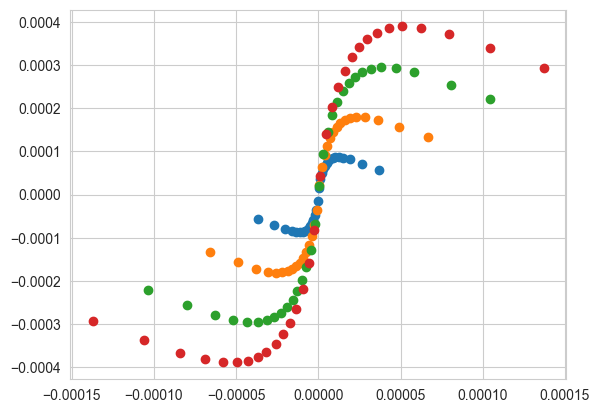

In [45]:
PLOTTING_LAGS = [10, 20, 50, 100, 150]
PLOTTING_LAGS = [x for x in PLOTTING_LAGS if x in RN_df['x_values'].values]

rn = RN_df[RN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']
qn = QN_df[QN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']

for lag in PLOTTING_LAGS:
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    imbalance = data_binned["vol_imbalance"].values
    indx = PLOTTING_LAGS.index(lag)
    response = rescaled_form(imbalance, rn.iloc[indx], qn.iloc[indx], alpha, beta)
    plt.scatter(imbalance, response)

[]

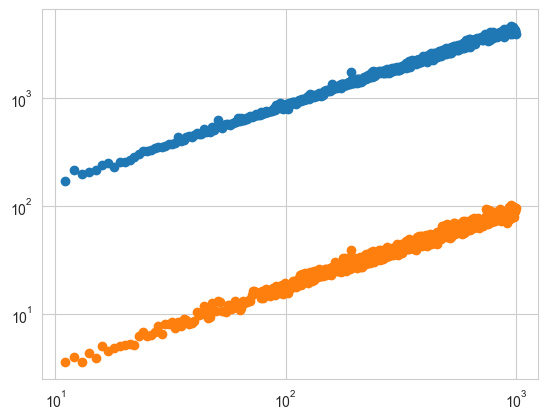

In [46]:
plt.scatter(RN_df['x_values'],RN_df['y_values'])
plt.scatter(QN_df['x_values'],QN_df['y_values'])
plt.loglog()

In [47]:
RN_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 21.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 34.243376287073396
alpha = 0.7046514589153091

Goodness of fit to data;
D = 0.02613240418118467
bic = 5273.130510313039
mape = 3.0032334784226298
Adjusted R-squared = 0.9915444240723101




In [48]:
QN_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 21.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.7138946658340644
alpha = 0.7057269991562459

Goodness of fit to data;
D = 0.020905923344947737
bic = 1614.5259857378246
mape = 6.860499484714514
Adjusted R-squared = 0.968111850380766




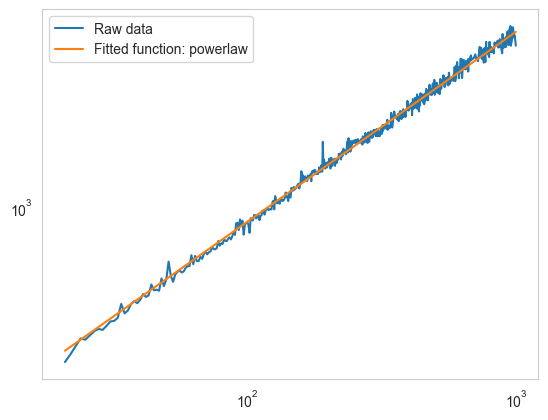

In [49]:
RN_fit_object.powerlaw.plot_fit()

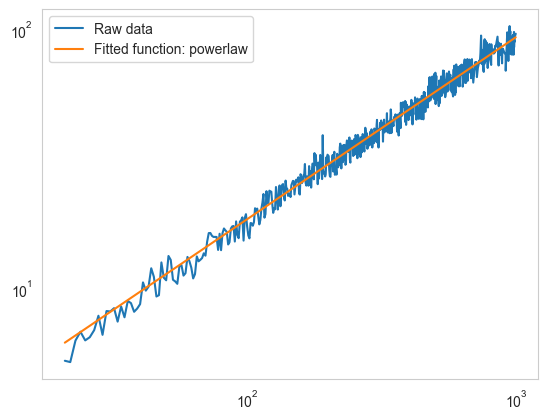

In [50]:
QN_fit_object.powerlaw.plot_fit()

In [51]:
chi = RN_fit_object.powerlaw.params.alpha
kappa = QN_fit_object.powerlaw.params.alpha

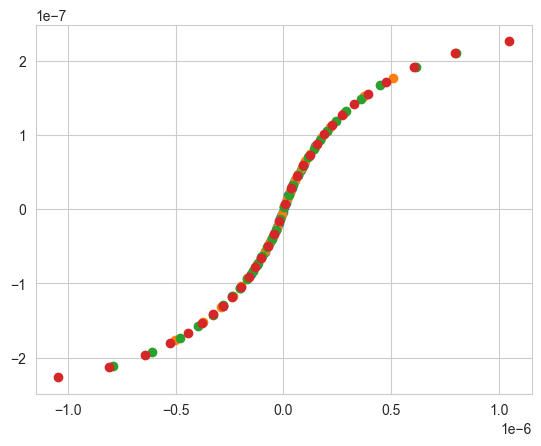

In [52]:
PLOTTING_LAGS = [10, 20, 50, 100, 150]
PLOTTING_LAGS = [x for x in PLOTTING_LAGS if x in RN_df['x_values'].values]

rn = RN_df[RN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']
qn = QN_df[QN_df['x_values'].isin(PLOTTING_LAGS)]['y_values']

for lag in PLOTTING_LAGS:
    data = norm_agg_features_df[norm_agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]

    data["vol_imbalance"] = data["vol_imbalance"] / T**kappa
    data["R"] = data["R"] / T**chi

    data_binned = bin_data_into_quantiles(data, q=31)
    imbalance = data_binned["vol_imbalance"].values
    indx = PLOTTING_LAGS.index(lag)
    response = rescaled_form(imbalance, chi, kappa, alpha, beta)
    plt.scatter(imbalance, response)